# Mulitscale segregation measures using a KL-divergence based method

This is an example notebook to demonstrate the use of this particular python module, segregation_distortion. This particular module from the distortion library can be used to calculate similar variations of a segregation measure, the distortion index over an entire city, given the population categories and the coordinates of spatial units. Other libraries are required to be installed before running the code. They are automatically installed when setting up the modules. 

### Requirements

In [11]:
#change indexes names and add a quick description of why the index is useful. 
#unit testing for the class framework
#GIO interface for uploading data and plotting the map
#make a script for command line
from divergence import segregation_distortion as seg
import geopandas as gdp
import pandas
import itertools as it
import matplotlib.pyplot as plt
import timeit

### Read in and analyse the data

Now let's actually read in some data to work with. The module is designed to run with any geolocated data, provided categorial variables are included as well as a geometry columns used by python for plotting and neighbourhood attribution. We will work with 1950 census data from Chicago. This data can be downloaded here (github link). We use Geopandas to load the dataframe. Check for more detailed documentation on Geopandas here (lien internet). 

In [12]:
geochicago=gdp.read_file('/Users/cdebezenac/Documents/chicago_segregation/data/chicago1950.shp')

We will want to get a better look at the raw data (although this set has already been cleaned up a bit) to check for empty, redundant cells or any other flaw that could make running our code difficult. 

In [13]:
print('There are ' + str(len(geochicago))+' tracts in Chicago.\n\n',geochicago.head(),geochicago.columns)

There are 937 tracts in Chicago.

       GISJOIN2    SHAPE_AREA TRACT  B0E001  B0E002  B0E003  B0E004  B0E005  \
0  17003100846  2.614179e+06  0846     460     150     105     110     175   
1  17003100867  3.333835e+05  0867      35      35      15      30      85   
2  17003100865  6.513552e+05  0865     125      55      35      45     110   
3  17003100863  7.972477e+04  0863      25      10      10       0      20   
4  17003100864  8.086402e+04  0864      20       5       5       5      10   

   B0E006  B0E007  ...  B0E014  B0E015  Total  White  Nonwhite  Negro  \
0     285     415  ...     140     420  11416  11411         5      4   
1      80     130  ...       5      25   3449   3446         3      0   
2     200     215  ...      30      50   4969   4966         3      3   
3       5      30  ...      10       5    842    842         0      0   
4       5      90  ...      10      20   1013   1013         0      0   

    % White  % Nonwhite   % Negro  \
0  0.999562    0.000

After a quick look at the variable dictionary, we can start to understand the data. The first columns represent administrative code for the area, the 'B0...' columns are attributed to income groups and the 'White','Nonwhite','Negro' represent the ethnic affiliation count in each tract. We note that 'Nonwhite' accounts for 'Negro' as well as others and that the 1950 naming convention is somewhat out of date. 

In [14]:
#seperate other from black
geochicago['Other']=geochicago['Nonwhite']-geochicago['Negro']
geochicago['% Other']=geochicago['% Nonwhite']-geochicago['% Negro']
#rename a column
geochicago.rename(columns={'Negro':'Black'},inplace=True)

### Create the city framework for segregation analysis

Let's now initialise our divergence object used as a city frame for the calculation of the indices. If we want to calculate the local indices for one single unit, we create an instance of the class LocalDivergenceProfile. If we wish to compare measures over all tracts, we use the DivergenceProfiles class from the div module. Initially, its attributes are: the dataframe given as a parameter, the variable names used for the population segmentation, the size of the city, the shape of the city, the coordinates of all units, a Demographics instance (see below), sup_distortion which is the greatest segregation index possible given the overall statistics of the city. The latter is used to normalise local indices. 

In [15]:
distortion_chicago=seg.DivergenceProfiles(geochicago,['White','Black','Other'])

14 spatial units have been left out because of null values over all groups. Check your data or continue.


/Users/cdebezenac/Documents/distortion/divergence/segregation_distortion.py:50: RuntimeWarning: divide by zero encountered in log
  log_relative_cumul = np.log(relative_cumul_proportions)


### Initialise the neighbourhood structure to compute the divergence profiles

The max_distortion index and the excepted_divergence indices are both spatial. Therefore, before calculating anything (see help(LocalDivergenceProfile) for detailed computation of indices) we will need to set up a neighbourhood structure with the set_neighbourhood() method. Keeping this example simple, we will simple use the default distance measure which is the crow distance between centroids of tracts. This method is quite computationnaly expensive as it orders all 937 neighbours of all 937 tracts! It has been sped up since previous versions by vectorising operations as much as possible using numpy. Parallelising the code could optimise it further but this technique has not been explored here. Nevertheless, from several hours (up to a whole day in the first tries), this will take a dozen seconds on the Chicago data. Note that the complexity is not linear, trying it out on London for example, with well over 1000 units will considerably slow down the process. 

In [6]:
%time distortion_chicago.set_neighbourhood(path='euclidean')

CPU times: user 12.9 s, sys: 9.62 ms, total: 12.9 s
Wall time: 12.9 s


Once the structure is known, the bulk of the work is done! The rest is numpy array operations on population counts (see divergence documentation for more detail). Setting the KL divergence profiles for all 937 units will only take a few seconds more!

In [7]:
%time distortion_chicago.set_profiles()

CPU times: user 6.93 s, sys: 16.8 ms, total: 6.95 s
Wall time: 6.95 s


### Update the data

Now we could use the raw data included in the DivergenceProfiles object, but we would rather use something we can actually plot easily using the basic geopandas library. So let's update the dataframe we fed into the city object and add columns representing the local variables and check if realistic indices have been added to the end. You may get a SettingWithCopyWarning when updating. While this should usually never be overlooked, this is raised because the attribute dataframe is a copy of the original one the user actually loads as a parameter. 

In [8]:
distortion_chicago.update_data()
#distortion_chicago.dataframe.head()

### View the results

Essentially, what the algorithm is doing to compute the local indices is summarise local profiles (described in the divergence documentation: max_index will average the superiour envelope of the profile). These trajectories can hide very relevant information on segregation as well as geographic patterns (neighbourhood definition for instance). For an overview, let's plot all of these. 

#### Profiles

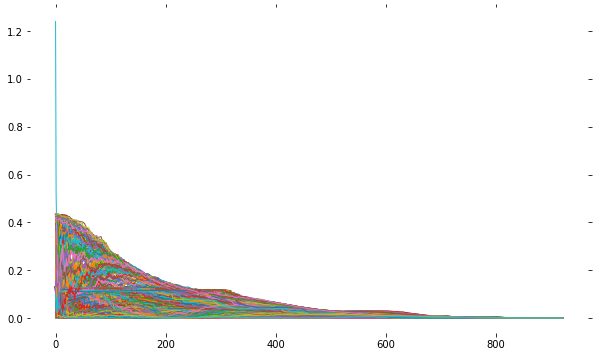

In [9]:
distortion_chicago.plot_profiles([i for i in range(920)],(10,6))

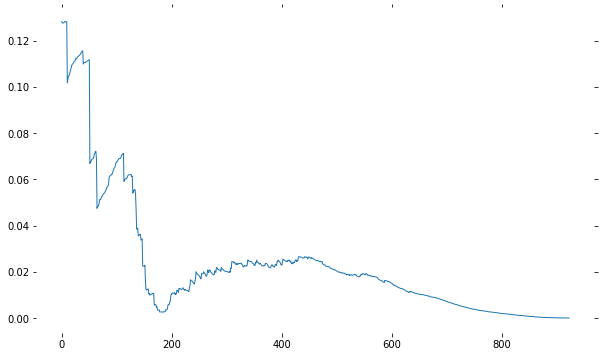

In [10]:
#isolate fewer profiles, here the profile of the unit indexed by 0:
distortion_chicago.plot_profiles([0],(10,6))

#### Index distribution

Another good way of getting a quick look at the results is to plot the distribution of the indices into histograms available with maplotlib. We will try to plot something a litle nicer than the default python plot and save it on to our computer. This is done with the plot_distribution() method of the DivergenceProfiles class. 

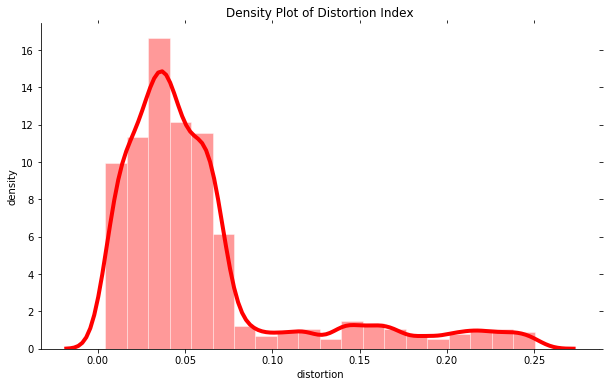

In [9]:
distortion_chicago.plot_distribution(variable='max_index')

#### Spatial representation: Chicago map

The most interesting attribute of local segregation measures are that you can plot them on to the map of the city using the plot_map() method.

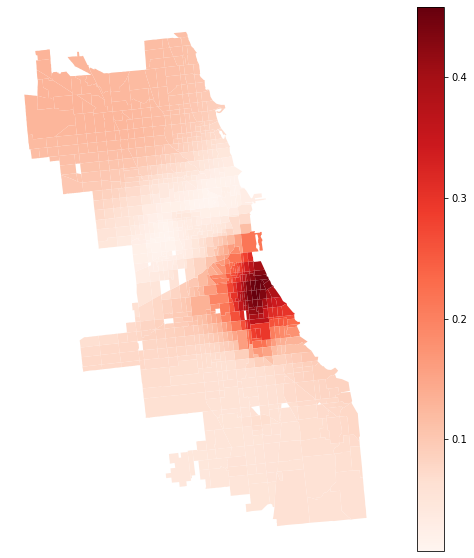

In [10]:
distortion_chicago.plot_map(variable='max_index_normal')

From this map, we can analyse the segregration trend in Chicago. The red tracts are those that have a high normalised distortion index. The most extreme values reach 45% of the value of the theoretically most segregated Chicago possible! They are visably all clustered in a middle easter area, where the first community of Blacks had settled before moving down south in the second half of the century. Chicago shows very high segregation between White and Black population. Although indices tend to decrease with time due to increased ethnic diversity, it still is one of the most striking examples among US cities. 

### Save the results

Once the dataframe has been updated it can be saved in shapefile format on to the user's computer by using the GeoPandas framework or using the built-in function in the DivergenceProfiles class, save_dataframe():

In [ ]:
distortion_chicago.save_dataframe('distortion_data_chicago')